In [33]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import frame_whitening as fw
import frame_whitening.simulation as fws

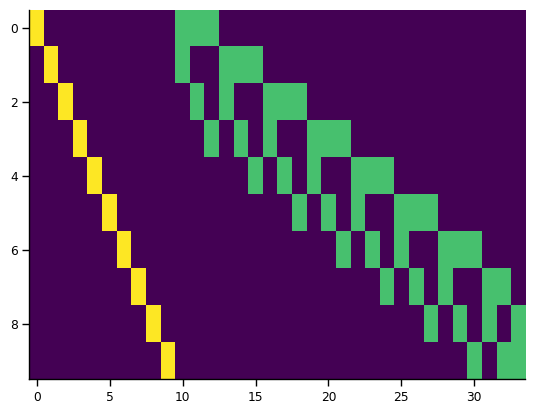

In [98]:
N = 10
neighborhood_size = 4
W = fw.get_conv_frame(N, 1, neighborhood_size, 1)
with sns.plotting_context("paper"):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(W, aspect="auto")
    sns.despine()

In [101]:
seed = 42069
rng = np.random.default_rng(seed)

A = rng.standard_normal((N, N))
Cxx = A @ A.T 
Cxx0 = Cxx + + 1e-4 * np.eye(N)

# simulate data
batch_size = -1
n_batch = 8192
step_skip = 1
g_last, g_all, errors, variances = fws.adapt_covariance(
                                        Cxx_list=[Cxx0], 
                                        W=W, 
                                        batch_size=-1, 
                                        n_batch=n_batch, 
                                        lr_g=3E-2,
                                        g0=None, 
                                        online=False, 
                                        clamp=False,
                                        alpha=1.,
                                        save_every=step_skip,
                                    )

Converged.:  53%|█████████████████████████████████████████████████████████████████▋                                                           | 4307/8192 [00:00<00:00, 6628.33it/s]


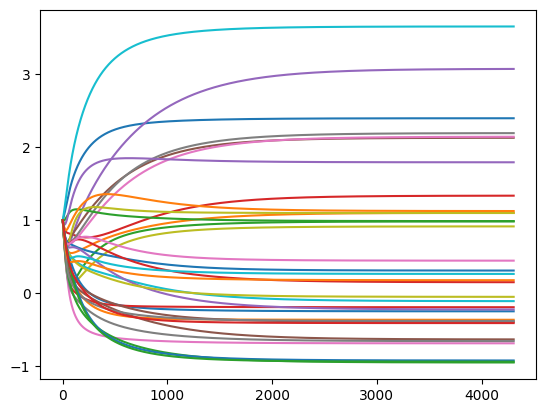

In [102]:
M = np.linalg.inv(np.eye(N) + W @ (g_last[0][:, None] * W.T))
plt.plot(g_all);

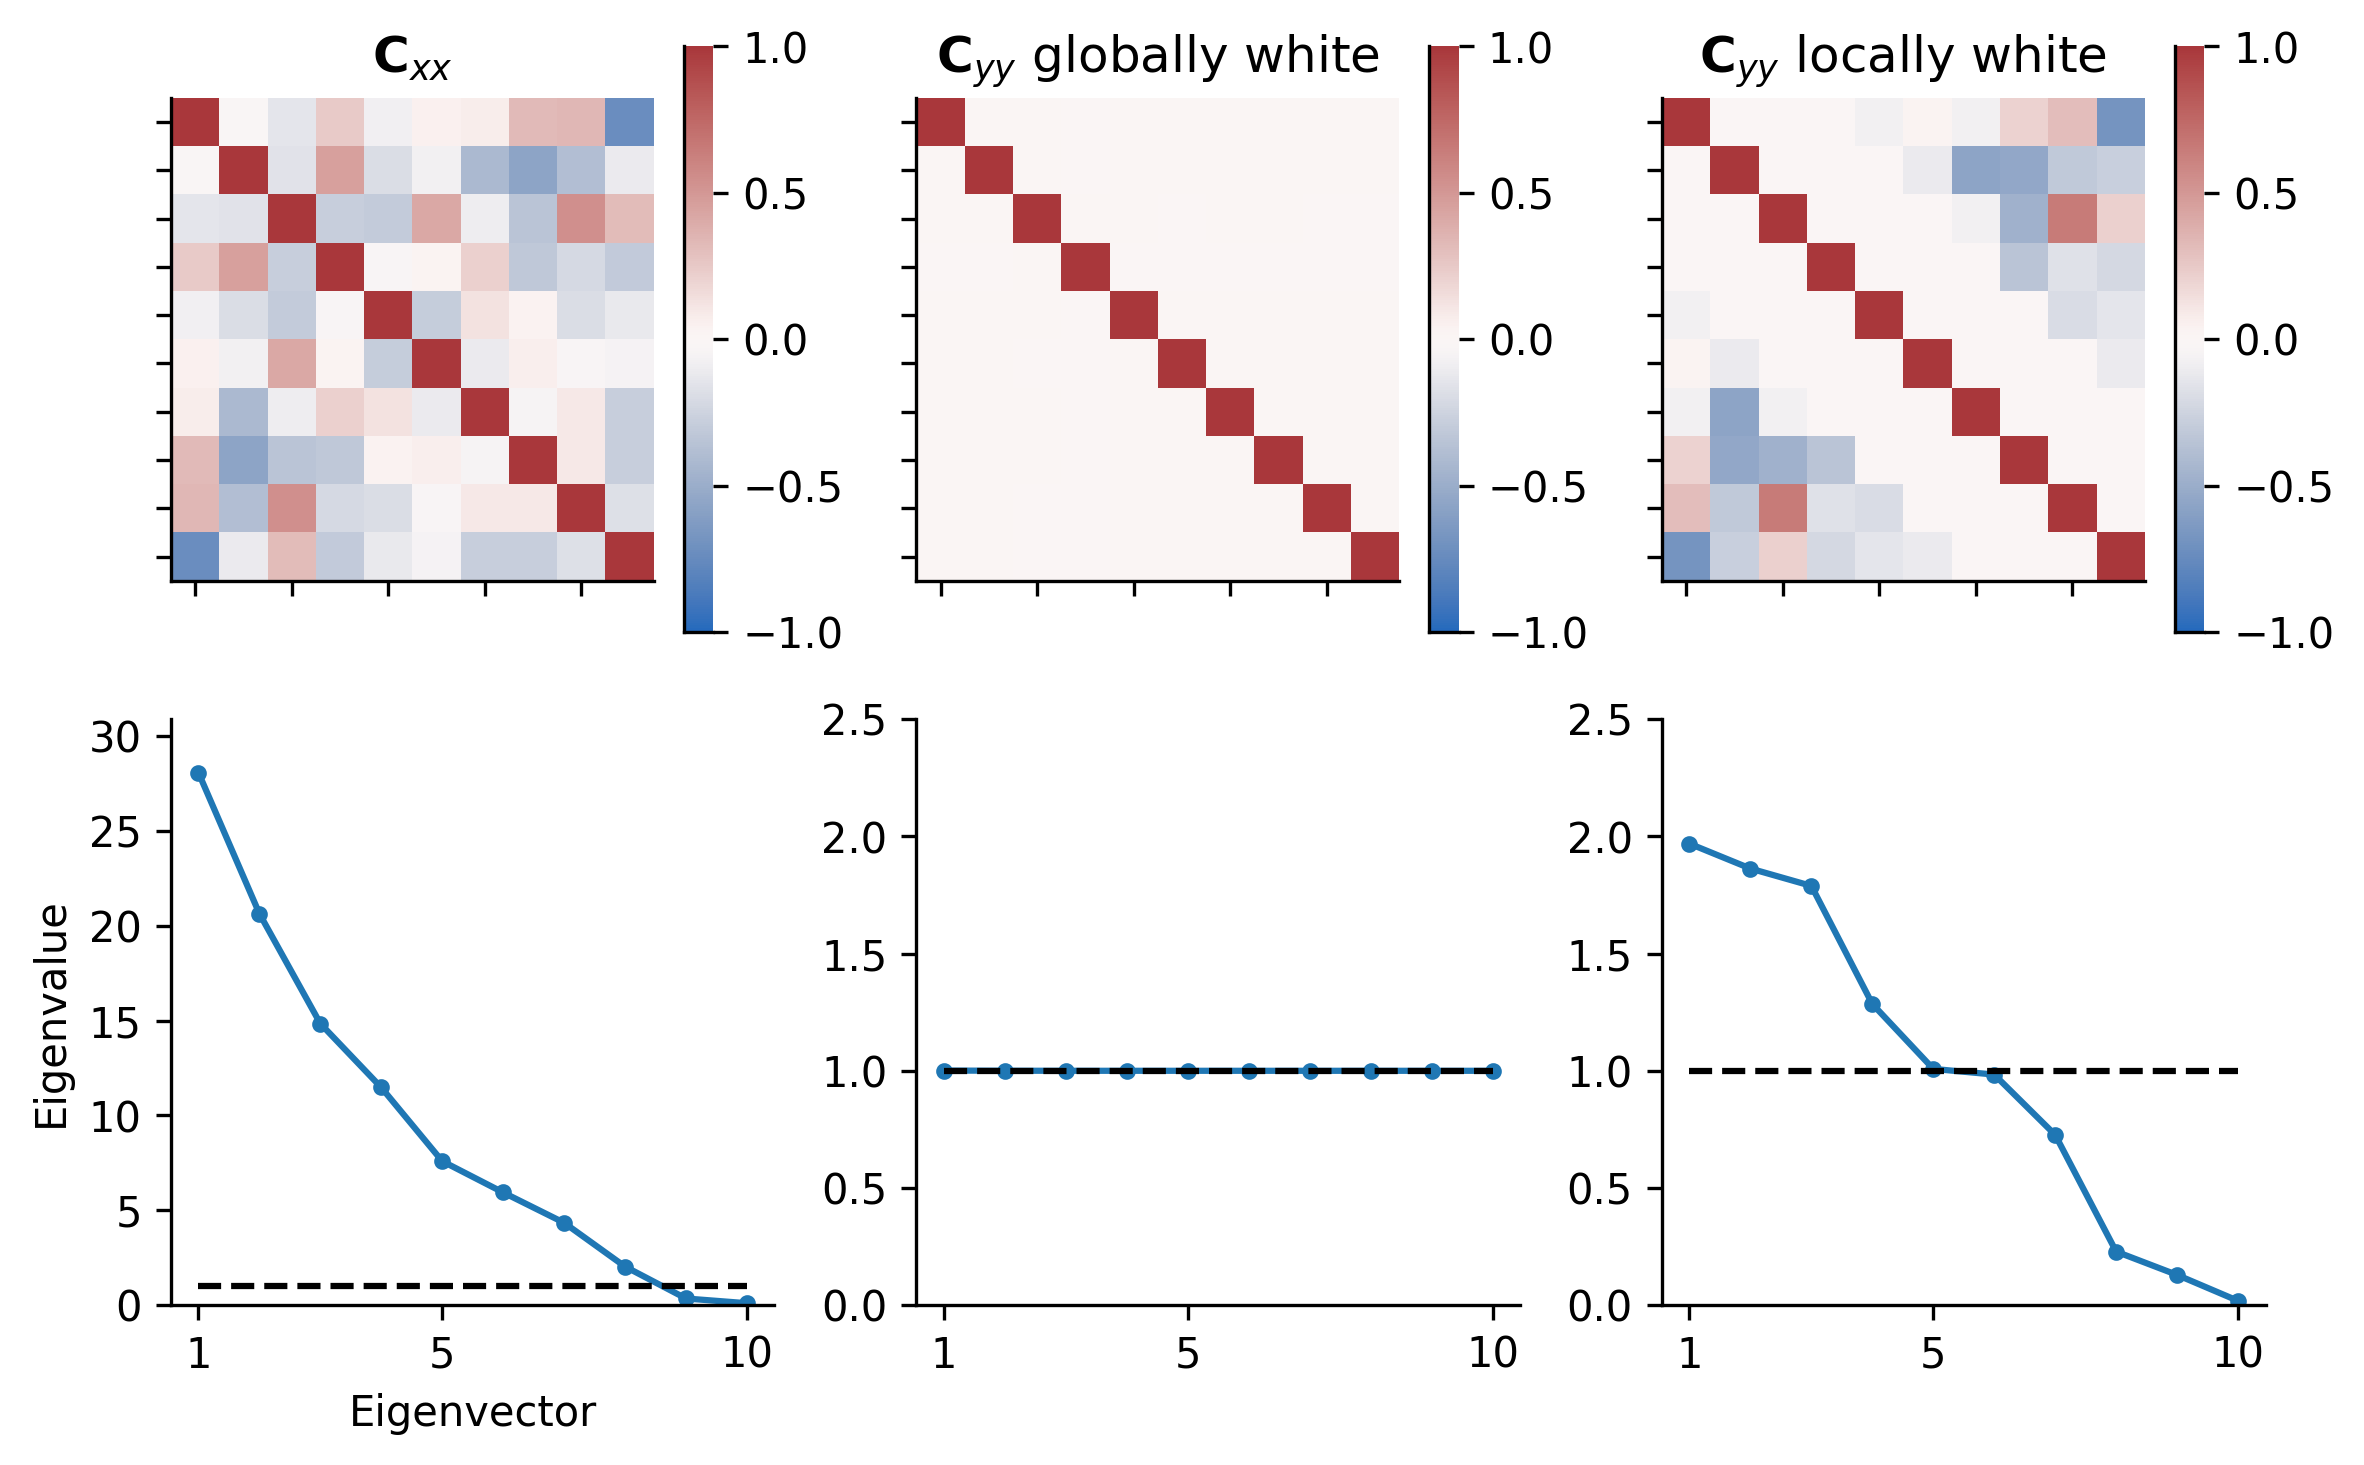

In [103]:
ev, V = np.linalg.eigh(Cxx)

Mw = V @ np.diag(1/np.sqrt(ev)) @ V.T

Cw2 = M @ Cxx0 @ M.T

vv, _ = np.linalg.eigh(Cw2)
Cww = Mw @ Cxx0 @ Mw.T

def normalize_cov(C):
    sig = np.sqrt(np.diag(C))
    corr = C / sig[:, None] / sig[None, :]
    return corr

def heatmap(C, ax):
    _VMAX = np.max(np.abs(C)) 
    sns.heatmap(C, ax=ax, vmin=-_VMAX, vmax=_VMAX, cmap="vlag", cbar=True, square=True)

fig, ax = plt.subplots(2, 3, figsize=(8, 5), dpi=300, sharex="row")

heatmap(normalize_cov(Cxx0), ax[0,0])
heatmap(normalize_cov(Cww), ax[0,1])
heatmap(normalize_cov(Cw2), ax[0,2])

ax[1,0].plot(np.arange(1,N+1), np.linalg.eigh(Cxx0)[0][::-1], ".-")
ax[1,1].plot(np.arange(1, N+1), np.linalg.eigh(Cww)[0][::-1], ".-")
ax[1,2].plot(np.arange(1, N+1), np.linalg.eigh(Cw2)[0][::-1], ".-")

ax[1,0].hlines(1, 1, N, color="k", linestyle="--")
ax[1,1].hlines(1, 1, N, color="k", linestyle="--")
ax[1,2].hlines(1, 1, N, color="k", linestyle="--")

ax[0,0].set(title=r"${\bf C}_{xx}$", xticklabels=[], yticklabels=[])
ax[0,1].set(title=r"${\bf C}_{yy}$ globally white", xticklabels=[], yticklabels=[])
ax[0,2].set(title=r"${\bf C}_{yy}$ locally white", xticklabels=[], yticklabels=[])

yscale = "linear"
ax[1, 0].set( yscale=yscale, 
    ylabel="Eigenvalue", xlabel="Eigenvector",
    xticks=(1, N//2, N), xticklabels=(1, N//2, N), ylim=(0, max(np.linalg.eigh(Cxx0)[0]) * 1.1))

_YMAX = 2.5
ax[1, 1].set( yscale=yscale, ylim=(0, _YMAX))
ax[1, 2].set( yscale=yscale, ylim=(0, _YMAX))

fig.tight_layout()
sns.despine()

## Toeplitz precision

Converged.:  29%|███████████████████████████████████▉                                                                                          | 585/2048 [00:00<00:00, 7615.62it/s]


[Text(0.5, 1.0, '${\\bf W}$ (neighborhood=3)')]

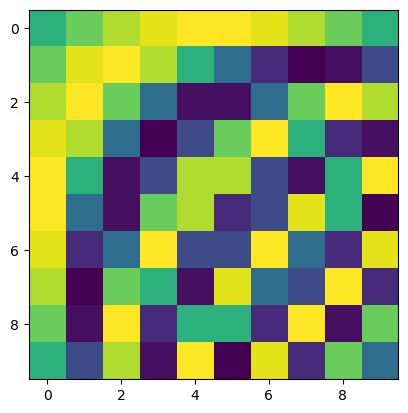

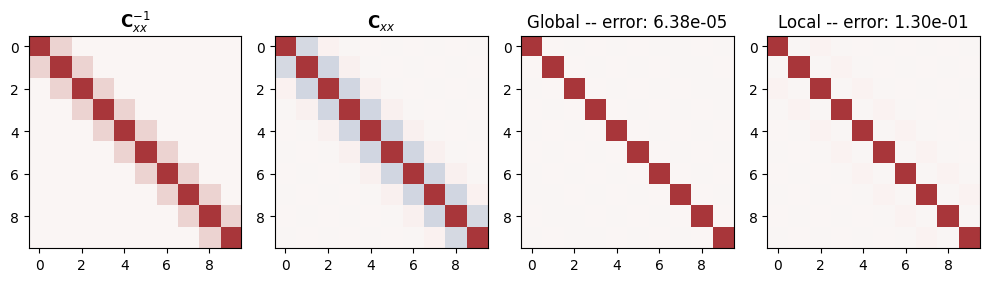

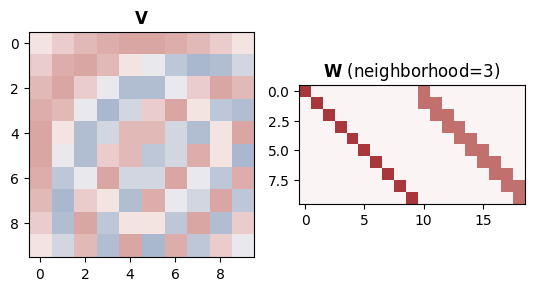

In [236]:
import scipy as sp

a = 0.2
P = sp.linalg.toeplitz((1, a, 0, 0, 0,0,0,0,0, a))
P[0,-1] = 0
P[-1,0] = 0
C = np.linalg.inv(P)

V = np.zeros(P.shape)
for i in range(1, P.shape[0]+1):
    for j in range(1, P.shape[0]+1):
        V[i-1, j-1] = np.sqrt(2/P.shape[0]+1) * np.sin(np.pi * (i*j)/(P.shape[0]+1))

plt.imshow(V)
V = fw.normalize_frame(V)
np.linalg.norm(V, axis=0)


# simulate data
batch_size = -1
n_batch = 2048
step_skip = 1
W = fw.get_conv_frame(P.shape[0], 1, 2, 1)

g_last, g_all, errors, variances = fws.adapt_covariance(
                                        Cxx_list=[C], 
                                        W=V, 
                                        batch_size=-1, 
                                        n_batch=n_batch, 
                                        lr_g=3E-2,
                                        g0=None, 
                                        online=False, 
                                        clamp=False,
                                        alpha=1.,
                                        save_every=step_skip,
                                    )
Mw = np.linalg.inv(np.eye(P.shape[0]) + V @ (g_last[0][:, None] * V.T))
g_last, g_all, errors, variances = fws.adapt_covariance(
                                        Cxx_list=[C], 
                                        W=W, 
                                        batch_size=-1, 
                                        n_batch=n_batch, 
                                        lr_g=3E-2,
                                        g0=None, 
                                        online=False, 
                                        clamp=False,
                                        alpha=1.,
                                        save_every=step_skip,
                                    )

M = np.linalg.inv(np.eye(P.shape[0]) + W @ (g_last[0][:, None] * W.T))

fig, ax = plt.subplots(1, 4, figsize=(10, 4))
ax[0].imshow(P, vmin=-1, vmax=1, cmap="vlag")
ax[1].imshow(C, vmin=-1, vmax=1, cmap="vlag")
ax[2].imshow(Mw@C@Mw.T, vmin=-1, vmax=1, cmap="vlag")
ax[3].imshow(M@C@M.T, vmin=-1, vmax=1, cmap="vlag")

error_global = (np.linalg.norm(np.eye(P.shape[0]) - Mw@C@Mw.T))
error_local = (np.linalg.norm(np.eye(P.shape[0]) - M@C@M.T))

ax[0].set(title=r"${\bf C}^{-1}_{xx}$")
ax[1].set(title=r"${\bf C}_{xx}$")
ax[2].set(title=f"Global -- error: {error_global:.2e}")
ax[3].set(title=f"Local -- error: {error_local:.2e}")

fig.tight_layout()

fig, ax = plt.subplots(1, 2)
ax[0].imshow(V, vmin=-1, vmax=1, cmap="vlag")
ax[1].imshow(W, vmin=-1, vmax=1, cmap="vlag")
ax[0].set(title=r"${\bf V}$")
ax[1].set(title=r"${\bf W}$ (neighborhood=3)")

## simulate dimensionality of matrix vector space

In [237]:
import scipy as sp
import scipy.linalg
n_repeats = 10000

N = 30

# get tri-diagonal mask
mask = np.eye(N)
for i in range(N-1):
    for j in range(i, i+2):
        mask[i,j] = 1
mask =  (mask + mask.T) > 0

p_all = []
c_all = []

idx = np.triu_indices(N)
for seed in range(n_repeats):
    rng = np.random.default_rng(seed)
    A = rng.standard_normal((N, N))

    P = (A @ A.T) * mask

    C12 = scipy.linalg.sqrtm(np.linalg.inv(P))

    # upper tri indices
    p_all.append(P[idx])
    c_all.append(C12[idx])

p_all = np.array(p_all)
c_all = np.array(c_all)

sigma_p = np.linalg.svd(p_all, compute_uv=False)
sigma_c = np.linalg.svd(c_all, compute_uv=False)

sigma_p /= np.max(sigma_p)
sigma_c /= np.max(sigma_c)

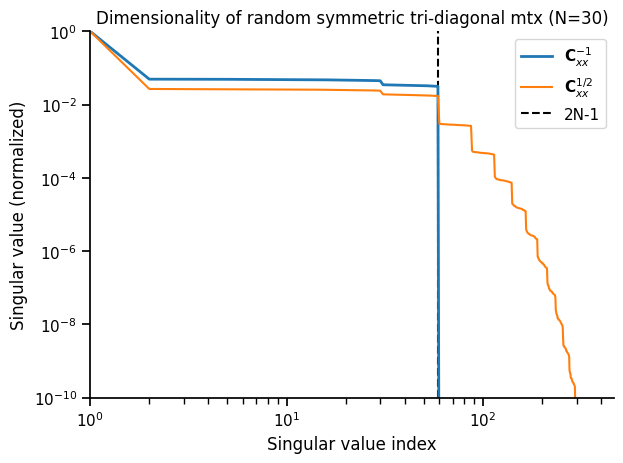

In [238]:
T = N*(N+1)//2
with sns.plotting_context("notebook"):
    fig, ax = plt.subplots(1, 1)
    ax.plot(np.arange(1, T+1), sigma_p, "-", label=r"${\bf C}^{-1}_{xx}$", linewidth=2)
    ax.plot(np.arange(1, T+1), sigma_c, "-", label=r"${\bf C}^{1/2}_{xx}$")
    ax.vlines(2*N-1, -1, 1, linestyles="--", color="k", zorder=-1, label="2N-1")
    ax.hlines(0, 1, T+1, linestyles="-", color="k", zorder=-1)

    ax.set(
        title=f"Dimensionality of random symmetric tri-diagonal mtx (N={N})",
        xlabel="Singular value index",
        ylabel="Singular value (normalized)",
        ylim=(1E-10, 1),
        xlim=(1, N*(N+1)//2),
        xscale="log",
        yscale="log"
    )
    ax.legend()
    sns.despine()
    fig.tight_layout()

## 1D images

Sample 1D "images" from a natural image.

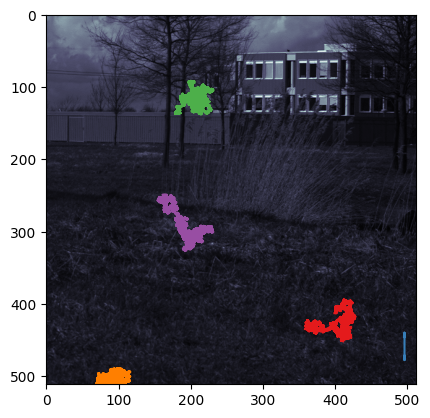

In [306]:
import os

import frame_whitening as fw
import frame_whitening.data as fwd
import frame_whitening.simulation as fws

data_dir = "/mnt/home/tyerxa/ceph/datasets/datasets/vanhateren_imc"
files = sorted(os.listdir(data_dir))
seed = 420
rng = np.random.default_rng(seed)

n_images = 10
images = fwd.load_images(n_images=n_images, crop_size=512, rng=rng)

images = [img / np.max(img) for img in images]

img = images[4]

patch_h, patch_w = 16, 1
img_h, img_w = img.shape

sigma = .3
n_steps = 20_000

fig, ax = plt.subplots(1, 1)
im = ax.imshow(img, cmap="bone")

n_contexts = 5
cols = sns.color_palette("Set1", n_contexts)

all_contexts, walk_coords = fwd.get_contexts(img, patch_h, patch_w, n_contexts, sigma, n_steps, pad_factor=1, rng=rng)
for idx, walk_hw in enumerate(walk_coords):
    walk_h, walk_w = walk_hw[:, 0], walk_hw[:, 1]
    ax.plot(walk_h, walk_w, color=cols[idx])




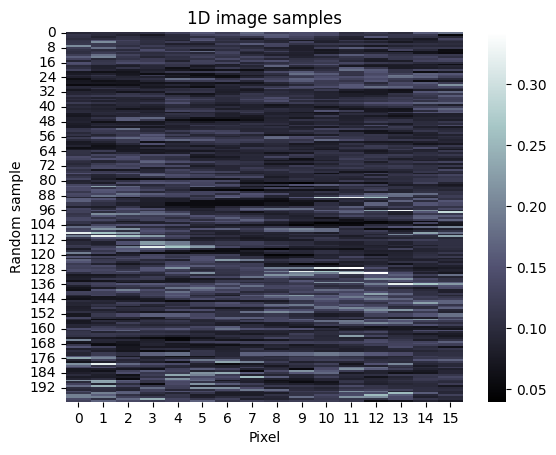

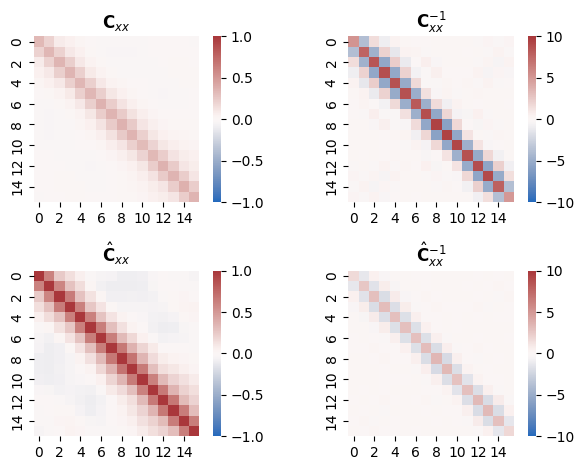

In [316]:
all_contexts = all_contexts.squeeze()

fig, ax = plt.subplots(1,1)
ctx = 0
sample_skip = 100
sns.heatmap(all_contexts[ctx][::sample_skip], ax=ax, cbar=True, cmap="bone")
ax.set(title="1D image samples", xlabel="Pixel", ylabel="Random sample")

X = all_contexts[ctx]
X0 = X.reshape(n_steps, -1)
X0 = X0 - np.mean(X0, axis=0)
X0 = X0 * 16

Cxx0 = np.cov(X0.T)
# Cxx0 = Cxx0 + np.eye(Cxx0.shape[0]) * 1e-4

Pxx0 = np.linalg.inv(Cxx0)

fig, ax = plt.subplots(2, 2)
ax = ax.flatten()
sns.heatmap(Cxx0, cbar=True, cmap="vlag", vmin=-1, vmax=1, ax=ax[0], square=True)
sns.heatmap(Pxx0, cbar=True, cmap="vlag", vmin=-10, vmax=10, ax=ax[1], square=True)

sns.heatmap(normalize_cov(Cxx0), cbar=True, cmap="vlag", vmin=-1, vmax=1, ax=ax[2], square=True)
sns.heatmap(np.linalg.inv(normalize_cov(Cxx0)), cbar=True, cmap="vlag", vmin=-10, vmax=10, ax=ax[3], square=True)

ax[0].set(title=r"${\bf C}_{xx}$")
ax[1].set(title=r"${\bf C}_{xx}^{-1}$")
ax[2].set(title=r"$\hat{\bf C}_{xx}$")
ax[3].set(title=r"$\hat{\bf C}_{xx}^{-1}$")
fig.tight_layout()